### Линейная регрессия: аналитическое решение с помощью NUMPY
Этапы:
- Загрузить данные и проанализировать датасет на предмет пропусков.
- Подготовить данные для подачи в модель: избавиться от пропусков, если они есть, и перекодировать категориальные признаки, если они представлены текстом.
- Построить модель. Будем строить несколько моделей линейной регрессии: первую — на одном признаке, вторую — на всех доступные признаках.
- Оценить качество модели.


In [1]:
# импортируем необходимые вспомогательные библиотеки:

import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
%matplotlib inline
plt.style.use('seaborn') #установка стиля matplotlib

Будем работать с датасетом из библиотеки sklearn о домах в Бостоне. Этот набор данных содержит информацию, собранную службой переписи населения США и касающуюся жилья в районе Бостона, штат Массачусетс.

Данный датасет содержится в модуле datasets библиотеки sklearn. Давайте загрузим датасет с помощью функции load_boston() и выведем его описание, обратившись по ключу 'DESCR':

In [2]:
from sklearn.datasets import load_boston 
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### Задача - научить модель предсказывать медианную стоимость дома на участке.

Составим DataFrame из наших данных. Для этого обратимся по ключу 'data' к загруженным данным и получим numpy-массив, в котором содержится информация обо всех признаках, а по ключу 'feature_names' содержатся названия признаков. Обратившись по ключу 'target', можно получить numpy-вектор со значениями целевой переменной — медианной стоимости занимаемых домов (MEDV).

In [3]:
#создаём DataFrame из загруженных numpy-матриц
boston_data = pd.DataFrame(
    data=boston.data, #данные
    columns=boston.feature_names #наименования столбцов
)
#добавляем в таблицу столбец с целевой переменной
boston_data['MEDV'] = boston.target
boston_data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
# Выведем информацию о таблице boston_data с помощью метода info():
boston_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


Примечание: 
- Модель линейной регрессии требует, чтобы в подаваемых ей на вход данных не было пропущенных значений.
- Также модель не умеет работать с категориальными признаками, представленными в виде типа object. Прежде чем подавать в модель линейной регрессии категориальные признаки, необходимо произвести кодировку категорий.

Построим линейную регрессию на одном признаке. Выберем признак, который имеет наиболее высокую линейную взаимосвязь. Для этого рассчитаем корреляцию признаков с целевой переменной и выберем наиболее влиятельный.

Для лучшего восприятия давайте построим столбчатую диаграмму для модульного значения корреляций:

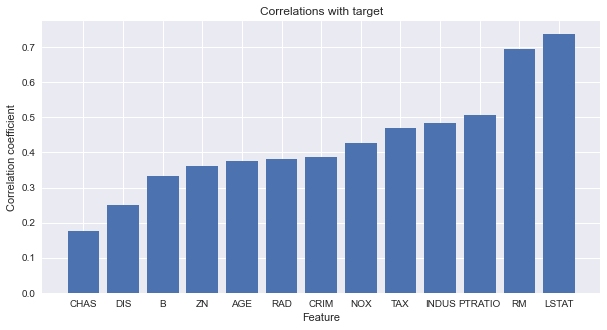

In [5]:
#Вычисляем модуль корреляции
corr_with_target = boston_data.corr()['MEDV'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('MEDV')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

Итак, самый коррелированный по модулю с медианной ценой (MEDV) признак — процент населения с низким статусом (LSTAT). Давайте построим линейную регрессию, используя этот признак.

In [6]:
X = boston_data[['LSTAT']] #матрица наблюдений
y = boston_data['MEDV'] #вектор правильных ответов
X.head()
#y.head()

,LSTAT
0,4.98
1,9.14
2,4.03
3,2.94
4,5.33


**Двойные квадратные скобки boston_data[['LSTAT']] позволяют выбрать признак из DataFrame, сохранив его в виде таблицы. Это важно, так как в формуле МНК x — это матрица.**

Напишем функцию linear_regression(), в которой реализуем вычисления коэффициентов. Аргументами функции будут матрица наблюдений X и вектор ответов y, а возвращать она будет вектор параметров w.

In [7]:
# Матричные вычисления легче всего реализовать через библиотеку numpy.
def linear_regression(X, y):
    #Создаём вектор из единиц
    ones = np.ones(X.shape[0])
    #Добавляем вектор к таблице первым столбцом
    X = np.column_stack([ones, X])
    #Вычисляем обратную матрицу Q
    Q = np.linalg.inv(X.T @ X)
    #Вычисляем вектор коэффициентов
    w = Q @ X.T @ y
    return w

In [8]:
# Осталось только вызвать нашу функцию и передать в неё нашу таблицу примеров X и столбец правильных ответов y. 
# Вычислим вектор параметров и выведем его на экран

#Вычисляем параметры линейной регрессии
w = linear_regression(X, y)
#Выводим вычисленные значения параметров в виде вектора
print('Vector w: {}'.format(w))
#Выводим параметры с точностью до двух знаков после запятой
print('w0: {:.2f}'.format(w[0]))
print('w1: {:.2f}'.format(w[1]))
# Vector w: [34.55384088 -0.95004935]
# w0: 34.55
# w1: -0.95

Vector w: [34.55384088 -0.95004935]
w0: 34.55
w1: -0.95


А значит сама модель будет иметь вид: y = 34.55 - 0.95x

Самое приятное в модели линейной регрессии — то, что её коэффициенты можно проинтерпретировать. 

Коэффициент w0 имитирует влияние сторонних факторов, которые не учтены в модели. Это значение медианной цены домов на участке, если бы значение процента населения с низким статусом было равно 0. 

Коэффициент w1 означает, на сколько в среднем изменится медианная цена (в тысячах долларов) при увеличении низкостатусного населения на 1 единицу. То есть если количество низкостатусного населения увеличится на 1 %, то медианная цена зданий на участке упадёт на 0.95 тысяч долларов. Можно сказать, что каждый новый процент низкостатусного населения уменьшает медианную цену на 0.95 тысяч долларов.

Теперь, если в данных появится новый участок Бостона с известной долей низкостатусного населения, мы сможем предсказать значение медианной стоимости домов простой подстановкой значений в модель:

In [10]:
#Задаём процент низкостатусного населения
x_example = 5.18 
#Делаем предсказание
y_predict = w[0] + w[1] * x_example
print('Predicted value: {:.2f}'.format(float(y_predict)))
#Predicted value: 29.63

Predicted value: 29.63


Так как мы работаем с одним фактором, то можем построить визуализацию нашей модели.

Давайте напишем функцию plot_regression_2d(), у которой будет три обязательных аргумента (матрица наблюдений X, столбец правильных ответов y и столбец с предсказаниями модели y_pred) и два аргумента по умолчанию (xlabel — подпись оси абсцисс и ylabel — подпись оси ординат).

Важно, чтобы данные были в формате np.array.

In [31]:
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    X = X.to_numpy() # приведим данные X к np.array
    #y_predict = y_predict.to_numpy() # приведим данные y_predict к np.array
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') #диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда

Сделаем предсказание для всех объектов из таблицы X, подставив её в модель линейной регрессии с найденными параметрами, и построим график:

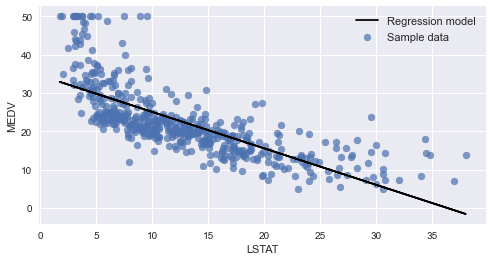

In [25]:
#Делаем предсказание для всех объектов из таблицы
y_predict = w[0] + w[1] * X
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Как и ожидалось, прямая является убывающей (коэффициент w1<0), и, если её продолжить влево, она пересечётся с осью ординат в точке w0=34.55. 

### Линейная регрессия: аналитическое решение с помощью SKLEARN
В модуле находится класс LinearRegression, который реализует аналитическое решение линейной регрессии. Для обучения модели необходимо просто вызвать метод fit(), передав в него матрицу наблюдений X и вектор правильных ответов y.

Данный метод реализует формулу метода наименьших квадратов и рассчитает параметры модели самостоятельно. Чтобы получить свободный член w0 нужно обратиться по атрибуту intercept_, а вектор параметров w1 будет храниться в атрибуте coef_

In [26]:
from sklearn import linear_model

#Создаём объект класса LinearRegression
lr_lstat = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_lstat.fit(X, y)
 
print('w0: {}'.format(lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm
 
# w0: 34.55384087938311
# w1: [-0.95004935]

w0: 34.5538408793831
w1: [-0.95004935]


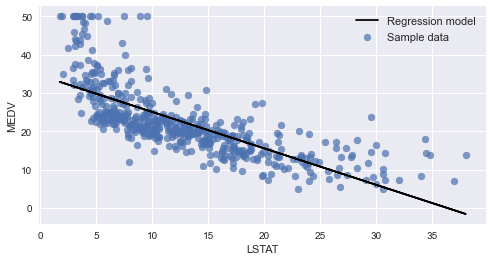

In [32]:
#Предсказываем медианную цену для всех участков из набора данных
y_predict = lr_lstat.predict(X)
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

Давайте выберем из таблицы boston все столбцы, исключая столбец с целевой переменной (MEDV). Полученную матрицу X и вектор правильных ответов y отправляем в метод fit(), чтобы произвести подгонку и найти параметры модели.

In [43]:
#Составляем список факторов (исключили целевой столбец)
features = boston_data.drop('MEDV', axis=1).columns
#Составляем матрицу наблюдений X и вектор ответов y
X = boston_data[features]
y = boston_data['MEDV']
#Создаём объект класса LinearRegression
lr_full = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_full.fit(X, y)

LinearRegression()

Для удобства составим DataFrame из коэффициентов w1,w2... обученной модели, не забыв добавить к нему строку со свободным членом w0

In [34]:
#Составляем таблицу из признаков и их коэффициентов
w_df = pd.DataFrame({'Features': features, 'Coefficients': lr_full .coef_})
#Составляем строку таблицы со свободным членом
intercept_df =pd.DataFrame({'Features': ['INTERCEPT'], 'Coefficients': lr_full .intercept_})
coef_df = pd.concat([w_df, intercept_df], ignore_index=True)
display(coef_df)

,Features,Coefficients
0,CRIM,-0.108011
1,ZN,0.046420
2,INDUS,0.020559
3,CHAS,2.686734
4,NOX,-17.766611
5,RM,3.809865
6,AGE,0.000692
7,DIS,-1.475567
8,RAD,0.306049
9,TAX,-0.012335


Итак, мы с вами построили две модели линейной регрессии: lr_lstat на одном признаке (LSTAT) и lr_full — на всех признаках в данных. Хотелось бы сравнить эти модели по их качеству. Может, нам достаточно только знаний о проценте низкостатусного населения, чтобы предсказать медианную цену?

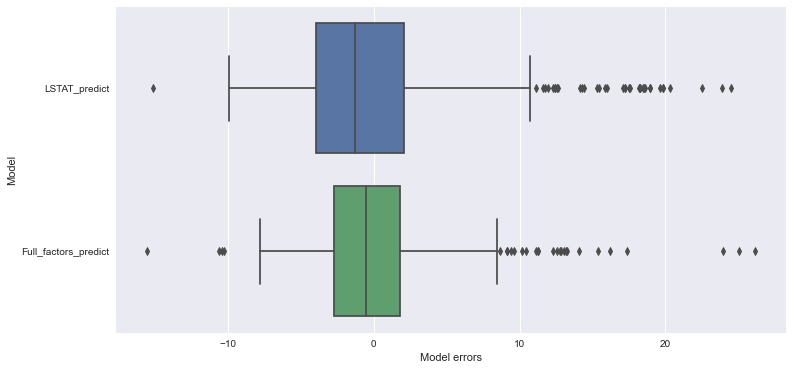

In [35]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура + координатная плоскость
#Ошибки модели на одном факторе LSTAT
y_errors_lstat = y - lr_lstat.predict(boston_data[['LSTAT']])
#Ошибки модели на всех факторах
y_errors_full = y - lr_full.predict(boston_data[features])
#Для удобства визуализации составим DataFrame из ошибок
errors_df = pd.DataFrame(
    {'LSTAT_predict': y_errors_lstat, 
     'Full_factors_predict': y_errors_full
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=errors_df, orient='h', ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат



Из построенных диаграмм ошибок видно, что разброс ошибок для модели, построенной на всех признаках, ниже (ящик уже и усы короче), и медиана ошибки также более приближена к 0. То есть можно сказать, что визуально качество второй модели выглядит лучше.

На обеих диаграммах присутствуют точки, сильно выбивающиеся за пределы усов. Это наблюдения, для которых модель допустила очень большую ошибку, по сравнению с основной группой.

Можно предположить, что это объекты, для которых гипотеза о линейной зависимости несправедлива, и линейной модели не хватает для предсказания целевой переменной для таких объектов.

### Задание 2.7
Сделайте предсказание медианной стоимости (MEDV) для данного участка c помощью модели lr_full. Введите результат предсказания в тысячах долларов.

In [51]:
ddf = pd.DataFrame(
    data=np.array([[0.35114,0.00000,7.38000,0.00000,0.49300,6.04100,49.90000,4.72110,5.00000,287.00000,19.60000,396.90000,7.70000]]),
    columns=boston.feature_names) #наименования столбцов
display(ddf)
lr_full.predict(ddf)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.35114,0.0,7.38,0.0,0.493,6.041,49.9,4.7211,5.0,287.0,19.6,396.9,7.7


array([22.86952447])

###  Задание 2.8
Дан набор данных о стартапах и их прибыли (в долларах) в трёх различных штатах США.

Столбцы:

        R&D Spend — расходы на исследования.
        Administration — административные расходы.
        Marketing Spend — расходы на маркетинг.
        State — штат.
        Profit — прибыль (целевой признак).

Для обучения линейной регрессии используйте R&D Spend, Administration и Marketing Spend. Отделите факторы от целевой переменной.

Обучите модель линейной регрессии методом наименьших квадратов с помощью библиотеки numpy (воспользуйтесь формулой из модуля).

Чему равны коэффициенты линейной регрессии при признаках R&D Spend, Administration и Marketing Spend? Ответ введите с точностью до второго знака после точки-разделителя.

In [52]:
# импортируем необходимые вспомогательные библиотеки:

import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
%matplotlib inline
plt.style.use('seaborn') #установка стиля matplotlib
from sklearn.datasets import load_boston 

In [55]:
startups = pd.read_csv('Data/50_Startups.csv')
display(startups.head())
display(startups.info())

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


None

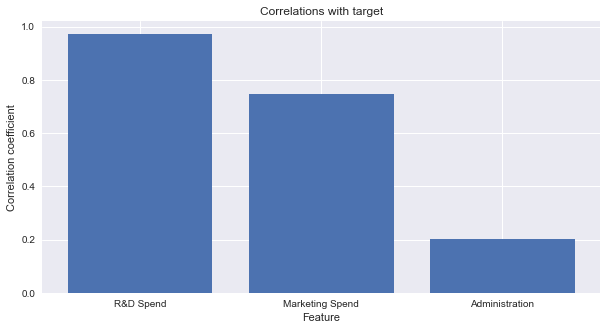

In [58]:
#Вычисляем модуль корреляции
corr_with_target_startups = startups.corr()['Profit'].abs().sort_values(ascending = False)
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target_startups = corr_with_target_startups.drop('Profit')
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(10, 5)) #фигура+координатная плоскость
ax.bar(corr_with_target_startups.index, corr_with_target_startups.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

In [78]:
def linear_regression(X, y):
    #Создаем вектор из единиц
    ones = np.ones(X.shape[0])
    #Добавляем вектор к таблице первым столбцом
    X = np.column_stack([ones, X])
    #Вычисляем обратную матрицу Q
    Q = np.linalg.inv(X.T @ X)
    #Вычисляем вектор коэффициентов
    w = Q @ X.T @ y
    return w
 
startups_data = pd.read_csv('data/50_Startups.csv')
#Разделяем факторы и целевой признак
X = startups_data[['R&D Spend', 'Administration', 'Marketing Spend']]
y = startups_data['Profit']
#Вычисляем параметры
w = linear_regression(X, y)
print('Vector w: {}'.format(w))
print('R&D Spend: {:.2f}'.format(w[1]))
print('Administration: {:.2f}'.format(w[2]))
print('Marketing Spend: {:.2f}'.format(w[3]))

Vector w: [ 5.01221930e+04  8.05715050e-01 -2.68159684e-02  2.72280648e-02]
R&D Spend: 0.81
Administration: -0.03
Marketing Spend: 0.03
